In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

In [3]:
from pathlib import Path
csvpath = Path('yen.csv')
df = pd.read_csv(csvpath, parse_dates=True, index_col='Date')

In [6]:
df['Return'] = df.Last.pct_change() * 100
df['Lagged_Return'] = df.Return.shift()
df = df.dropna()
df.head()

C:\Users\markp\AppData\Local\Temp/ipykernel_328/880088158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'] = df.Last.pct_change() * 100
C:\Users\markp\AppData\Local\Temp/ipykernel_328/880088158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lagged_Return'] = df.Return.shift()


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.173913,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,-0.010248,-0.173913
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970,-0.010248
2014-02-26,9784.0,9795.0,9746.0,9760.0,29.0,9760.0,118559.0,200105.0,-0.296251,0.327970


In [25]:
df = df.dropna()
Returns = df.Settle.pct_change() * 100
df = df.assign(Returns = Returns)
df = df.dropna()
# In this case, you may have to replace inf, -inf values with np.nan"s
df = df.replace({pd.NA:np.nan})
df['Lagged_Return'] = pd.DataFrame(df['Returns']).sort_index(ascending= False).Returns.shift()

# Slice the data into Training and Testing data

In [26]:
train = df[:'2017']
test = df['2018':]

In [27]:
# Create dataframes for X_train and X_test
# Create series for y_train and y_test
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

# Fit the model to the Training Data

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
#Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [33]:
# And make a prediction of "y" values for just the test dataset
predictions = model.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [15]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

In [16]:
Results.head(2)

,Return,Predicted Return
Date,,
2018-01-02,0.331144,-0.007028
2018-01-03,-0.190199,-0.006225


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

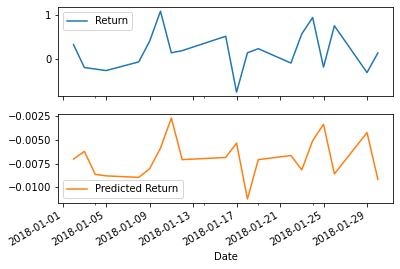

In [17]:
# Plot the first 20 predictions and actual returns separetely
# The trends lines should be similar
Results[:20].plot(subplots=True)

<AxesSubplot:xlabel='Date'>

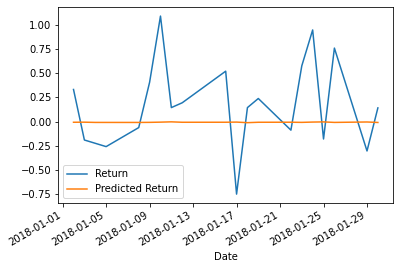

In [18]:
# Plot the first 20 predictions against the true values in the same plot to see how it performed
# The lines should be as close as possible
Results[:20].plot()

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4066899341765545


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [34]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that DataFrame:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.6019810895137193
